In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import time
sns.set()

In [2]:
def get_vocab(file, lower = False):
    with open(file, 'r') as fopen:
        data = fopen.read()
    if lower:
        data = data.lower()
    data = data.split()
    vocab = list(set(data))
    return data, vocab

def embed_to_onehot(data, vocab):
    onehot = np.zeros((len(data), len(vocab)), dtype = np.float32)
    for i in range(len(data)):
        onehot[i, vocab.index(data[i])] = 1.0
    return onehot

In [3]:
text, text_vocab = get_vocab('shakespeare.txt', lower = True)

In [4]:
learning_rate = 0.01
batch_size = 16
sequence_length = 32
epoch = 3000
num_layers = 2
size_layer = 256
possible_batch_id = range(len(text) - sequence_length - 1)

In [5]:
class Model:
    def __init__(self, num_layers, size_layer, dimension, sequence_length, learning_rate):
        def lstm_cell():
            return tf.nn.rnn_cell.LSTMCell(size_layer, sequence_length, state_is_tuple = False)
        self.rnn_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(num_layers)], 
                                                     state_is_tuple = False)
        self.X = tf.placeholder(tf.float32, (None, None, dimension))
        self.Y = tf.placeholder(tf.float32, (None, None, dimension))
        self.hidden_layer = tf.placeholder(tf.float32, (None, num_layers * 2 * size_layer))
        self.outputs, self.last_state = tf.nn.dynamic_rnn(self.rnn_cells, self.X, 
                                                          initial_state = self.hidden_layer, 
                                                          dtype = tf.float32)
        rnn_W = tf.Variable(tf.random_normal((size_layer, dimension)))
        rnn_B = tf.Variable(tf.random_normal([dimension]))
        self.logits = tf.matmul(tf.reshape(self.outputs, [-1, size_layer]), rnn_W) + rnn_B
        y_batch_long = tf.reshape(self.Y, [-1, dimension])
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, 
                                                                           labels = y_batch_long))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(self.cost)
        self.correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(y_batch_long, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        seq_shape = tf.shape(self.outputs)
        self.final_outputs = tf.reshape(tf.nn.softmax(self.logits), 
                                        (seq_shape[0], seq_shape[1], 
                                         dimension))

In [6]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(num_layers, size_layer, len(text_vocab), sequence_length, learning_rate)
sess.run(tf.global_variables_initializer())

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
def train_random_sequence():
    LOST, ACCURACY = [], []
    pbar = tqdm(range(epoch), desc = 'epoch')
    for i in pbar:
        last_time = time.time()
        init_value = np.zeros((batch_size, num_layers * 2 * size_layer))
        batch_x = np.zeros((batch_size, sequence_length, len(text_vocab)))
        batch_y = np.zeros((batch_size, sequence_length, len(text_vocab)))
        batch_id = random.sample(possible_batch_id, batch_size)
        for n in range(sequence_length):
            id1 = embed_to_onehot([text[k + n] for k in batch_id], text_vocab)
            id2 = embed_to_onehot([text[k + n + 1] for k in batch_id], text_vocab)
            batch_x[:,n,:] = id1
            batch_y[:,n,:] = id2
        last_state, _, loss = sess.run([model.last_state, model.optimizer, model.cost], 
                                       feed_dict = {model.X: batch_x, 
                                                    model.Y: batch_y,
                                                    model.hidden_layer: init_value})
        accuracy = sess.run(model.accuracy, feed_dict = {model.X: batch_x, 
                                                         model.Y: batch_y, 
                                                         model.hidden_layer: init_value})
        ACCURACY.append(accuracy); LOST.append(loss)
        init_value = last_state
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    return LOST, ACCURACY

In [9]:
LOST, ACCURACY = train_random_sequence()

epoch: 100%|██████████| 3000/3000 [33:51<00:00,  1.50it/s, accuracy=0.881, cost=2.97] 


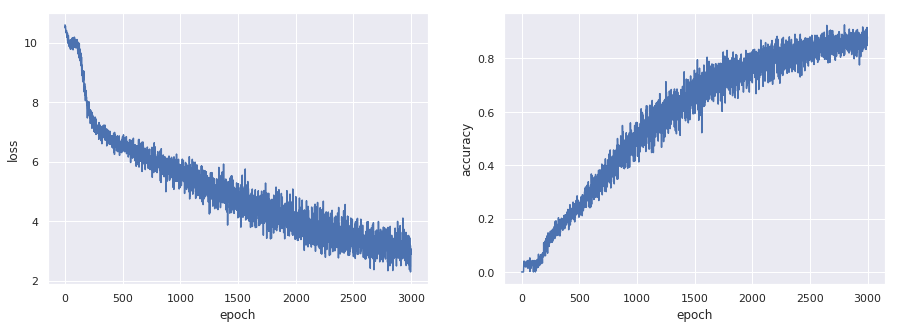

In [10]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
EPOCH = np.arange(len(LOST))
plt.plot(EPOCH, LOST)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()

In [23]:
split_text = text
selected_index = np.random.randint(0, len(split_text) - 5)
tag = split_text[selected_index:selected_index + 5]
print(tag)

['should', 'begin', 'and', 'end,', 'but']


In [33]:
def generate_based_sequence(length_sentence, argmax = False):
    sentence_generated = tag[:]
    onehot = embed_to_onehot(tag, text_vocab)
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    for i in range(len(tag)):
        batch_x = np.zeros((1, 1, len(text_vocab)))
        batch_x[:, 0, :] = onehot[i, :]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    for i in range(length_sentence):
        if argmax:
            index = np.argmax(prob[0][0])
        else:
            index = np.random.choice(range(len(text_vocab)), p = prob[0][0])
        element = [text_vocab[index]]
        sentence_generated += element
        onehot = embed_to_onehot(element, text_vocab)
        batch_x = np.zeros((1, 1, len(text_vocab)))
        batch_x[:, 0, :] = onehot[0, :]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    return ' '.join(sentence_generated)


In [34]:
print(generate_based_sequence(100,True))

should begin and end, but will lose those he hath won. brutus: in that there's comfort. sicinius: doubt not the commoners, for whom we say we will be witnesses. petruchio: father, and wife, and gentlemen, adieu; i will to venice; sunday comes apace: we will have rings and things and them, we will be witnesses. petruchio: father, and thou taught me love, or thy brother a lord it is the duke of the field by tewksbury when oxford had me no more than your poor marcius: cominius: they are all to be you in a fair canon, must i be command?' let me be a


In [35]:
print(generate_based_sequence(100,False))

should begin and end, but will lose those he evil. the aching doth renown'd for sweet gifts; in honourable royal. we'll home! remain. pause, and most distemper'd kingdom fool to call upon a son thus rued a head which that art sin to sounds: thoughts, which is hastings: do more ones; but when you would were anger'd, and he, their all biondello? come, i menenius: a fellow strumpet-- brutus: not devise one say you can picked then heinous can you slaughter-man all aged man pardon,-- the kiss. learn'd, be not the friends. gloucester: send me prince's some robs some goodly aves the slaves! sort not
